In [ ]:
!pip install chromadb sentence-transformers langchain

In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
import matplotlib.pyplot as plt
from langchain.tools import tool

##work on frames

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
folder_path = "/content/Untitled Folder"

In [23]:
def search_images(folder_path, query , topk = 2) :
  image_files = [f for f in os.listdir(folder_path)
              if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

  if not image_files:
    print("empty file")
    return []

  images = [Image.open(os.path.join(folder_path, img_file)) for img_file in image_files]

  inputs = processor(text=query, images=images, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image
  prob = logits_per_image
  results = list(zip(image_files, prob.tolist()))

  results.sort(key=lambda x: x[1], reverse=True)
  top_filenames = [os.path.splitext(filename)[0] for filename, _ in results[:topk]]

  for i , (filename , score) in  enumerate(results[:topk]):
    img = Image.open(os.path.join(folder_path, filename))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


  return top_filenames

#search in text "RAG"

###create simulate data

In [6]:
import json

##start working on text

###imports

In [7]:
import google.generativeai as genai
import numpy as np
import datetime as dt
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb
from chromadb.utils import embedding_functions
import json

##set LLMs , open folders ,..

In [20]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key= GOOGLE_API_KEY)

In [21]:
llm = genai.GenerativeModel("gemini-2.0-flash")
embeddings = "paraphrase-multilingual-MiniLM-L12-v2"

In [10]:
with open('transcript.json', 'r', encoding='utf-8') as f:
    segments = json.load(f)

##start the RAG

### vector chromaDB "https://docs.trychroma.com/docs/overview/introduction"

In [11]:
def split_text_into_chunks(segments):
  text_spilliter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separators=["\n", "۔", "؟", "!", " ", ""]
  )
  chunks = []
  for segment in segments:
    text_chunks = text_spilliter.split_text(segment["text"])

    for chunk in text_chunks:
        chunks.append({
            "text": chunk,
            "start_time": segment["audio_start"],
            "end_time": segment["audio_end"]
        })

  return chunks

In [13]:
chunks = split_text_into_chunks(segments["segments"])

In [14]:
def initializeDB(embeddings,chunks):
  client = chromadb.PersistentClient(path="/content/vector_db")
  embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
  model_name= embeddings
  )
  collection = client.create_collection(
    name="tts_collection1",
    embedding_function=embedding_func
  )

  collection.add(
    documents=[chunk["text"] for chunk in chunks],

    metadatas = [{
      "start_time": chunk["start_time"],
      "end_time": chunk["end_time"]
  } for chunk in chunks],

  ids=[str(i) for i in range(len(chunks))]
  )
  return collection

In [ ]:
collection = initializeDB(embeddings,chunks)

In [16]:
def Retrive_similar(collection , query, top_k=2):
  results = collection.query(
      query_texts = query,
      n_results = top_k,
      include=["documents", "metadatas"]
  )
  return [
        {
            "text": doc,
            "start_time": meta["start_time"],
            "end_time": meta["end_time"]
        }
        for doc, meta in zip(results["documents"][0], results["metadatas"][0])
    ]

###Generate answer using LLM

In [17]:
def generate_Answer(collection , query):
  similar_chunks = Retrive_similar(collection , query)

  context = "\n\n".join(
        f"[{chunk['start_time']}-{chunk['end_time']}] {chunk['text']}"
        for chunk in similar_chunks
    )

  prompt = f"""
    استخدم المقاطع التالية فقط للإجابة.
    المقاطع:
    {context}

    السؤال: {query}

    المتطلبات:
    1. أجب بالعربية الفصحى فقط
    2. اذكر الأوقات بين [] إذا وجدت
    3. لا تختلق معلومات
    4. إجابة مختصرة (2-3 جمل)

    مثال:
    [00:01:00] يمكنك تفعيل الميزة من الإعدادات
    """
  response = llm.generate_content(prompt)
  return response.text

In [18]:
@tool
def answer_frames_rags(collection,query, folder_path , topk):
  """Answers questions by combining image and text search results.

  Args:
    collection: The ChromaDB collection for text search.
    query: The text query to use for searching.
    folder_path: The path to the folder containing images for image search.
    topk: The number of top image results to return.

  Returns:
    A tuple containing the image search results and the generated text answer.
  """
  prompt = f"""

  you are an expert in translation from Arabic to English
  translate that {query} only to English
  the translated data will send to clip model
  """
  response = llm.generate_content(prompt)
  image = search_images(folder_path , response.text , topk)
  text = generate_Answer(collection , response.text )
  print("Frame timestamp : " ,image)
  print("Answer : " , text)
  return image , text

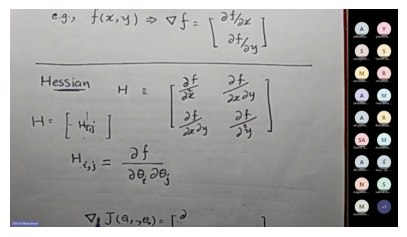

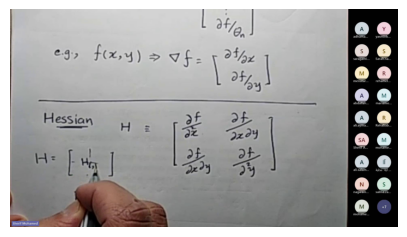

Frame timestamp :  ['00-16-13-882', '00-05-08-064']
Answer :  [275.33-303.934] الهيسيان هو عملية مصفوفة وهو ببساطة دالة لعدة معلمات، ثيتا. [361.762-390.11] هي مصفوفة يتم فيها اشتقاق كل متغير مرتين، والعملية تعادل المشتقة الثانية.



In [24]:
image , text = answer_frames_rags.run({"collection": collection, "query": "ما هو الهيسيان ماتريكس", "folder_path": folder_path, "topk": 2})
